# AutoDecoders on the ModelNet 10 data

### Change directory to kaolin

The kaolin library must be downloaded from <https://github.com/NVIDIAGameWorks/kaolin> and installed with instructions from their README

### Note: The setenv.sh script must be run to set up proper kaolin paths

In [2]:
# import necessary libraries
import kaolin as kal
from kaolin.datasets import modelnet
from torch.utils.data import DataLoader
from torchvision import transforms

import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import visualize_npy
from functools import partial

%matplotlib inline

## Kaolin mesh to point cloud conversion functions

In [129]:
def convert_mesh_to_pt_cloud(mesh, num_points=5000):
    return kal.conversions.trianglemesh_to_pointcloud(mesh, num_points)[0]

In [186]:
category_list = ['bathtub', 'bed',        'chair',  'desk',  'dresser', 
                 'monitor', 'night_stand', 'sofa',  'table',  'toilet']

In [193]:
def unload_off_to_npy(category_list, dump_npy_dir='./data/ModelNet10_npy/'):
    for category in category_list:
        print(f"Unloading {category} to npy")
        mdnet = modelnet.ModelNet(root='./data/ModelNet10/', categories=[category],
                                  transform=transforms.Compose([custom_mesh_to_pount_cloud]))

        data_loader = DataLoader(mdnet, batch_size=32,
                                 shuffle=True, num_workers=0)
        X = None
        # Load the entire .off files into one Tensor object X one at a time
        for data_batch in data_loader:
            if X is None:
                X = data_batch[0]
            else:
                X = torch.cat([X, data_batch[0]], dim=0)
        dump_npy_file = 'modelnet_'+category+'.npy'
        print(
            f"Dumped category {category} with shape {X.shape} under {dump_npy_dir} as {dump_npy_file}")
        np.save(dump_npy_dir+dump_npy_file, X.numpy())

## Unload all .off files into a .npy pickle format

WARNING: Requires a lot of time

The original `.off` ModelNet10 files must be downloaded from <https://modelnet.cs.princeton.edu/>

In [194]:
unload_off_to_npy(category_list)

Unloading bathtub to npy
Dumped category bathtub with shape torch.Size([106, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_bathtub.npy
Unloading bed to npy
Dumped category bed with shape torch.Size([515, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_bed.npy
Unloading chair to npy
Dumped category chair with shape torch.Size([889, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_chair.npy
Unloading desk to npy
Dumped category desk with shape torch.Size([200, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_desk.npy
Unloading dresser to npy
Dumped category dresser with shape torch.Size([200, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_dresser.npy
Unloading monitor to npy
Dumped category monitor with shape torch.Size([465, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_monitor.npy
Unloading night_stand to npy
Dumped category night_stand with shape torch.Size([200, 5000, 3]) under ./data/ModelNet10_npy/ as modelnet_night_stand.npy
Unloading sofa to npy
Dumped catego

## Library imports for autodecoder ensemble nets

In [1]:
import os
import sys
import time
import math
import random
import numpy as np
import matplotlib.pylab as plt

from pathlib import Path

# Try importing tqdm notebook
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError as e:
    print('tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm', e)
    import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import joblib
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss, log_loss
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# CUSTOM IMPORTS

# utility functions
from utils import chamfer_loss, visualize_npy, print_model_metrics  

# TODO UNCOMMENT when implemented
# from utils import chamfer_loss, HyperParameter, DirectorySetting

# TODO UNCOMMENT when implemented
# from nn_modles import AutoDecoder, CompNet, EnsembleCompNet       # autodecoder, comp_net, and ensemble_compnet modules
# from dataset_module import PointDriftDS, EncodingDS, EncodingDS   # dataset modules


%matplotlib inline

tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm No module named 'tqdm.notebook'


# Training our AutoDecoder Ensemble CompNets on the ModelNet10 data

In [2]:
def get_train_test_from_npy(data_src, test_split=0.1, shuffle_seed=None):
    """
    Returns X_train, X_test, y_train, y_test
    if shuffle_seed is None, X and y will not be shuffled
    """
    X, y = None, None
    label = 0
    for path in Path(data_src).iterdir():
        X_curr = np.load(path)
        if X is None and y is None:
            X = X_curr
            y = np.full((X_curr.shape[0], 1), label, dtype=np.int64)
        else:
            X = np.concatenate([X, X_curr], axis=0)
            y = np.concatenate([y, np.full((X_curr.shape[0], 1), label, dtype=np.int64)],
                               axis=0)
        label += 1
        print(f"Adding {path} to X. X is now {X.shape}")

    if shuffle_seed is not None:
        np.random.seed(shuffle_seed)
        shuffled_idxs = np.random.permutation(X.shape[0])
        X, y = X[shuffled_idxs], y[shuffled_idxs]
        
    test_idx_end = int(X.shape[0]*0.1)
    X_train, X_test = X[test_idx_end:], X[:test_idx_end]
    y_train, y_test = y[test_idx_end:], y[:test_idx_end]

    return X_train, X_test, y_train, y_test

In [3]:
data_src = './data/ModelNet10_npy/'

X_train, X_test, y_train, y_test = get_train_test_from_npy(data_src, shuffle_seed=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Adding data/ModelNet10_npy/modelnet_chair.npy to X. X is now (889, 5000, 3)
Adding data/ModelNet10_npy/modelnet_sofa.npy to X. X is now (1569, 5000, 3)
Adding data/ModelNet10_npy/modelnet_night_stand.npy to X. X is now (1769, 5000, 3)
Adding data/ModelNet10_npy/modelnet_bed.npy to X. X is now (2284, 5000, 3)
Adding data/ModelNet10_npy/modelnet_table.npy to X. X is now (2676, 5000, 3)
Adding data/ModelNet10_npy/modelnet_toilet.npy to X. X is now (3020, 5000, 3)
Adding data/ModelNet10_npy/modelnet_monitor.npy to X. X is now (3485, 5000, 3)
Adding data/ModelNet10_npy/modelnet_bathtub.npy to X. X is now (3591, 5000, 3)
Adding data/ModelNet10_npy/modelnet_dresser.npy to X. X is now (3791, 5000, 3)
Adding data/ModelNet10_npy/modelnet_desk.npy to X. X is now (3991, 5000, 3)


((3592, 5000, 3), (399, 5000, 3), (3592, 1), (399, 1))

-------
## Declaring the required modules and functions

### Setting up CUDA devices

In [4]:
device = None
use_cuda = torch.cuda.is_available()

if use_cuda:
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of CUDA device in use is 0


### Hyperparameter Classes

In [5]:
class HyperParameter:
    def __init__(self,
                 l2_reg=None,
                 encoding_size=256,
                 encoding_iters=50,
                 num_point_cloud=3,
                 epochs=4,
                 lr=0.00001,
                 batch_size=32):

        self.l2_reg = l2_reg
        self.learning_rate = lr
        self.encoding_size = encoding_size
        self.encoding_iters = encoding_iters
        self.num_point_cloud = num_point_cloud
        self.epochs = epochs
        self.batch_size = batch_size

    def __repr__(self):
        return f"l2_reg: {self.l2_reg}\n" + \
               f"learning_rate: {self.learning_rate}\n" + \
               f"encoding_size: {self.encoding_size}\n" + \
               f"encoding_iters: {self.encoding_iters}\n" + \
               f"num_point_cloud: {self.num_point_cloud}\n" + \
               f"epochs: {self.epochs}\n" + \
               f"batch_size: {self.batch_size}\n"


class DirectorySetting:

    def __init__(self,
                 DATA_DIR="./data",
                 OUTPUT_DIR="./tranformed/",
                 AUTODECODER_TRAINED_WEIGHT_DIR="./autodecoder_trained_weights",
                 CLASSIFIER_TRAINED_WEIGHT_DIR="./classifier_trained_weights"):

        self.AUTODECODER_TRAINED_WEIGHT_DIR = AUTODECODER_TRAINED_WEIGHT_DIR
        self.CLASSIFIER_TRAINED_WEIGHT_DIR = CLASSIFIER_TRAINED_WEIGHT_DIR
        self.OUTPUT_DIR = OUTPUT_DIR
        self.DATA_DIR = DATA_DIR

        os.makedirs(self.AUTODECODER_TRAINED_WEIGHT_DIR, exist_ok=True)
        os.makedirs(self.CLASSIFIER_TRAINED_WEIGHT_DIR, exist_ok=True)
        os.makedirs(self.OUTPUT_DIR, exist_ok=True)

    def __repr__(self):
        return f"DATA_DIR: {self.DATA_DIR}\n" + \
               f"OUTPUT_DIR: {self.OUTPUT_DIR}\n" + \
               f"AUTODECODER_TRAINED_WEIGHT_DIR: {self.AUTODECODER_TRAINED_WEIGHT_DIR}\n" + \
               f"CLASSIFIER_TRAINED_WEIGHT_DIR: {self.CLASSIFIER_TRAINED_WEIGHT_DIR}\n"

In [6]:
DEBUG = True
SEED  = 17*19

HP = HyperParameter(epochs=10,
                    l2_reg=None, 
                    batch_size=16,
                    num_point_cloud=3,
                    encoding_iters=1000, 
                    encoding_size=256)
DS = DirectorySetting()

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

### Neural Network Modules

In [7]:
class AutoDecoder(nn.Module):
    """
    AutoDecoder NN to learn point drift (latent encoding) between two 3D shapes
    """

    def __init__(self,  encoding_dim=256, point_dim=3):
        super(AutoDecoder, self).__init__()
        self.fc1 = nn.Conv1d(encoding_dim + point_dim, 128, 1)
        self.fc2 = nn.Conv1d(128, 64, 1)
        self.fc3 = nn.Conv1d(64, point_dim, 1)

    def forward(self, X, encoding):
        num_points = X.shape[-1]  # num of points in each shape
        enc = encoding.unsqueeze(-1).repeat(1, 1, num_points)
        X_enc = torch.cat([X, enc], 1)
        X_enc = F.leaky_relu(self.fc1(X_enc))
        X_enc = F.leaky_relu(self.fc2(X_enc))

        # Return the drift from obj X determined by the latent encoding
        return X + self.fc3(X_enc)


class CompNet(nn.Module):
    """
    Ingests the latent encoding of two 3D objects 
    and outputs the similarity score
    """

    def __init__(self, encoding_size=256):
        super(CompNet, self).__init__()
        self.fc1 = nn.Linear(encoding_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, encoding):
        X = F.leaky_relu(self.fc1(encoding))
        return torch.sigmoid(self.fc2(X))


class EnsembleCompNet(nn.Module):
    """
    Ingests the latent encoding of two 3D objects 
    and outputs the similarity score using an ensemble of CompNets
    Stacked Ensemble
    """

    def __init__(self, comp_net=CompNet, num_ensemble=5, encoding_dim=256, seed_val=SEED):
        """
        if comp_net is a module, EnsembleCompNet creates num_ensemble*comp_net NN modules
        if comp_net is a list of modules, EnsembleCompNet iterates through comp_net to get the NN modules
        """
        super(EnsembleCompNet, self).__init__()
        self.ensemble_compnet = nn.ModuleList()

        if isinstance(comp_net, list):
            if num_ensemble != len(comp_net):
                raise IndexError(
                    f"Length of comp_nets: {len(comp_net)} and num_ensemble: {num_ensemble} do not match")
            comp_net_list = comp_net
            for i in range(num_ensemble):
                self.ensemble_compnet.append(comp_net_list[i])
        else:
            for i in range(num_ensemble):
                torch.manual_seed(seed_val*i+1)
                if use_cuda:
                    torch.cuda.manual_seed(seed_val*i+1)
                self.ensemble_compnet.append(comp_net(encoding_dim))
        self.final = nn.Linear(num_ensemble, 1)

    def forward(self, encoding):
        """ Returns the final value of the results after a nn.Linear layer """
        total_pred = torch.cat([net(encoding)
                                for net in self.ensemble_compnet])
        total_pred = total_pred.reshape(-1, len(self.ensemble_compnet))

        return torch.sigmoid(self.final(total_pred))

### Dataset modules

In [8]:
class PointNetDS(Dataset):
    """
    Create train dataset
    """

    def __init__(self, data, sampling_interval=3):
        # sample every sampling_interval-th point to speed up
        self.data = data.transpose((0, 2, 1))[:, :, ::sampling_interval]
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]


class PointDriftDS(Dataset):
    """
    Pairs each shape with one shape from the same class and one shape from a different class
    """

    def __init__(self, data, labels, sampling_interval=3):
        # sample every sampling_interval-th point to speed up
        self.data = data.transpose((0, 2, 1))[:, :, ::sampling_interval]
        self.labels = labels.squeeze()

        self.same_cls = []
        self.diff_cls = []
        idx_arr = np.arange(self.data.shape[0])
        same_idx = []
        diff_idx = []
        for i in range(self.labels.max() + 1):
            same_idx.append(idx_arr[self.labels == i])
            diff_idx.append(idx_arr[self.labels != i])
        for i in range(data.shape[0]):
            same = same_idx[self.labels[i]]
            diff = diff_idx[self.labels[i]]
            self.same_cls.append(same[random.randint(0, len(same) - 1)])
            self.diff_cls.append(diff[random.randint(0, len(diff) - 1)])
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        X = self.data[idx]
        same_cls_data = self.data[self.same_cls[idx]]
        diff_cls_data = self.data[self.diff_cls[idx]]

        return X, same_cls_data, diff_cls_data, idx


class EncodingDS(Dataset):
    """
    Generate encoding for each pair of shapes in the PointDriftDS
    """

    def __init__(self, PDDS, autodecoder, latent_size=256):
        self.PointDriftDS = PDDS
        self.autodecoder = autodecoder
        self.latent_size = latent_size
        self.same_cls = torch.zeros((len(self.PointDriftDS), latent_size))
        self.diff_cls = torch.zeros((len(self.PointDriftDS), latent_size))

    def train_encodings(self, num_iterations=50, lr=0.01, l2_reg=False, batch_size=16):
        dl = DataLoader(self.PointDriftDS,
                        batch_size=batch_size, shuffle=False)
        i = 0
        batch_cnt = 0
        same_cls_loss = 0.0
        diff_cls_loss = 0.0
        self.autodecoder.eval()

        for batch_idx, (x, y, z, idx) in enumerate(dl):
            j = i + len(idx)
            loss, encoding = find_encoding(x, y, self.autodecoder, encoding_iters=num_iterations,
                                           encoding_size=self.latent_size, lr=lr, l2_reg=l2_reg,)
            same_cls_loss += loss
            self.same_cls[i:j] = encoding
            loss, encoding = find_encoding(x, z, self.autodecoder, encoding_iters=num_iterations,
                                           encoding_size=self.latent_size, lr=lr, l2_reg=l2_reg,)
            diff_cls_loss += loss
            self.diff_cls[i:j] = encoding

            i = j
            batch_cnt += 1
        print("Encodings trained")
        return (self.same_cls, self.diff_cls, same_cls_loss / batch_cnt, diff_cls_loss / batch_cnt)

    def __len__(self):
        return len(self.PointDriftDS)

    def __getitem__(self, idx):
        return (*self.PointDriftDS[idx], self.same_cls[idx], self.diff_cls[idx])

### Train and test modules

In [9]:
def find_encoding(X, y, autodecoder, encoding_iters=300,
                  encoding_size=256, lr=5e-4, l2_reg=False):
    """
    Generate the encoding (latent vector) for each data in X
    """

    def _adjust_lr(initial_lr, optimizer, num_iters, decreased_by, adjust_lr_every):

        lr = initial_lr * ((1 / decreased_by) **
                           (num_iters // adjust_lr_every))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    decreased_by = 10
    adjust_lr_every = encoding_iters // 2

    encoding = torch.ones(X.shape[0], encoding_size).normal_(
        mean=0, std=1.0 / math.sqrt(encoding_size)).cuda()

    encoding.requires_grad = True
    optimizer = torch.optim.Adam([encoding], lr=lr)
    loss_num = 0

    for i in range(encoding_iters):
        autodecoder.eval()
        _adjust_lr(lr, optimizer, i, decreased_by, adjust_lr_every)
        optimizer.zero_grad()
        y_pred = autodecoder(X, encoding)
        loss = chamfer_loss(y_pred, y, ps=y.shape[-1])

        if l2_reg:
            loss += 1e-4 * torch.mean(encoding.pow(2))
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(i, loss.cpu().data.numpy(), encoding.norm())
        loss_num = loss.cpu().data.numpy()

    return loss_num, encoding

In [10]:
def train_decoder(HP, DS, train_ds, test_ds=None, decoder=None, save_wt_fname='decoder.pth'):
    """ 
    Default training is for 3D point dimensions
    
    Suggested Settings
        EPOCHS = 10
        point_dim = 3
        batch_size = 16
        learning_rate = 0.001
        encoding_size = 256
        
    Set save_wt_fname to None to disable weight saves
    """
    EPOCHS = HP.epochs
    point_dim = HP.num_point_cloud
    batch_size = HP.batch_size
    encoding_size = HP.encoding_size
    lr = HP.learning_rate
    
    if decoder is None:
        adnet = AutoDecoder(encoding_size, point_dim)
    else:
        adnet = decoder
    adnet = adnet.cuda()

    # encodings for same class transformation
    same_encoding = torch.nn.Embedding(
        len(train_ds), encoding_size, max_norm=1.0)
    # init encoding with Kaiming Initialization
    torch.nn.init.normal_(same_encoding.weight.data,
                          0.0,
                          1.0 / math.sqrt(encoding_size))

    # encodings for different class transformation
    diff_encoding = torch.nn.Embedding(
        len(train_ds), encoding_size, max_norm=1.0)
    # init encoding with Kaiming Initialization
    torch.nn.init.normal_(diff_encoding.weight.data,
                          0.0,
                          1.0 / math.sqrt(encoding_size))

    optimizer = torch.optim.Adam([
        {"params": adnet.parameters(), "lr": lr, },
        {"params": same_encoding.parameters(), "lr": lr, },
        {"params": diff_encoding.parameters(), "lr": lr, }, ])

    op_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    adnet = nn.DataParallel(adnet)
    adnet.cuda()

    data_loader_train = DataLoader(train_ds, batch_size=batch_size,
                                   shuffle=True)
    
    for epoch in range(0, EPOCHS):
        adnet.train()
        same_total_loss = 0.0
        diff_total_loss = 0.0

        for batch_idx, (x, y, z, idx) in enumerate(data_loader_train):
            optimizer.zero_grad()
            x, y, z = x.cuda(), y.cuda(), z.cuda()
            x, y, z = (Variable(x).float(),
                       Variable(y).float(),
                       Variable(z).float())
            y_pred = adnet(x, same_encoding(torch.LongTensor(idx)))
            loss_cham = chamfer_loss(y, y_pred, ps=y.shape[-1])
            same_total_loss += loss_cham.data.cpu().numpy()
            loss_cham.backward()

            z_pred = adnet(x, diff_encoding(torch.LongTensor(idx)))
            loss_cham = chamfer_loss(z, z_pred, ps=z.shape[-1])
            diff_total_loss += loss_cham.data.cpu().numpy()
            loss_cham.backward()

            optimizer.step()
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"Epoch: {epoch}. batch_idx: {batch_idx}")
                print("Loss: ",same_total_loss / 100, diff_total_loss / 100)
                same_total_loss = 0.0
                diff_total_loss = 0.0
        op_schedule.step(epoch)

        if test_ds is not None and epoch % 5 == 0:
            print("Eval: ", eval_decoder(adnet, test_ds, batch_size=batch_size))

    if save_wt_fname is not None:
        torch.save(adnet.module.state_dict(), DS.AUTODECODER_TRAINED_WEIGHT_DIR + '/' + save_wt_fname)
    return adnet

In [11]:
def eval_decoder(decoder, eval_ds, batch_size=16):
    decoder.eval()
    encoding_ds = EncodingDS(eval_ds, decoder)
    return encoding_ds.train_encodings(num_iterations=10, lr=0.05, batch_size=batch_size)[2:]

In [12]:
def train_compnet(HP, DS, train_ds, test_ds=None, compnet=None, save_wt_fname='compnet.pth'):
    """
    Train the CompNet

    Suggested Parameters
    EPOCHS=10
    batch_size=16
    encoding_size=256
    learning_rate=0.001
    """
    EPOCHS = HP.epochs
    point_dim = HP.num_point_cloud
    batch_size = HP.batch_size
    encoding_size = HP.encoding_size
    lr = HP.learning_rate

    if compnet is None:
        cpnet = CompNet(encoding_size=encoding_size)
    else:
        cpnet = compnet
    cpnet = cpnet.cuda()

    optimizer = torch.optim.Adam(cpnet.parameters(), lr=lr)
    op_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    cpnet = nn.DataParallel(cpnet)
    cpnet.cuda()

    data_loader_train = DataLoader(train_ds, batch_size=batch_size,
                                   shuffle=True)

    loss_fn = nn.BCELoss()
    for epoch in range(EPOCHS):
        same_total_loss = 0.0
        diff_total_loss = 0.0
        cpnet.train()
        for batch_idx, (x, y, z, idx, same_cls, diff_cls) in enumerate(data_loader_train):
            optimizer.zero_grad()

            same_cls, diff_cls = same_cls.cuda(), diff_cls.cuda()
            same_cls, diff_cls = Variable(
                same_cls).float(), Variable(diff_cls).float()

            same_pred = cpnet(same_cls)
            same_target = torch.ones(same_pred.shape).float().cuda()
            same_loss = loss_fn(same_pred, same_target)
            same_loss.backward()
            same_total_loss += same_loss.data.cpu().numpy()

            diff_pred = cpnet(diff_cls)
            diff_target = torch.zeros(diff_pred.shape).float().cuda()
            diff_loss = loss_fn(diff_pred, diff_target)
            diff_loss.backward()
            diff_total_loss += diff_loss.data.cpu().numpy()

            optimizer.step()
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"Epoch: {epoch}. batch_idx: {batch_idx}")
                print("Loss: ", same_total_loss / 100, diff_total_loss / 100)
                same_total_loss = 0.0
                diff_total_loss = 0.0
        op_schedule.step(epoch)

        if test_ds is not None and epoch % 5 == 0:
            print("Eval: ", eval_compnet(cpnet, test_ds, batch_size=batch_size))

    if save_wt_fname is not None:
        torch.save(cpnet.module.state_dict(),
                   DS.CLASSIFIER_TRAINED_WEIGHT_DIR + '/' + save_wt_fname)
    return cpnet

In [13]:
def eval_compnet(cpnet, test_ds, batch_size=16, pred_threshold=0.5):
    cpnet.eval()
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    loss_fn = nn.BCELoss()

    same_total_loss = 0.0
    diff_total_loss = 0.0
    batch_cnt = 0
    same_corr_cnt = 0.0
    diff_corr_cnt = 0.0
    same_incorr_cnt = 0.0
    diff_incorr_cnt = 0.0

    for batch_idx, (x, y, z, idx, same_cls, diff_cls) in enumerate(test_dl):
        batch_cnt += 1
        same_cls, diff_cls = same_cls.cuda(), diff_cls.cuda()

        same_pred = cpnet(same_cls)
        same_target = torch.ones(same_pred.shape).float().cuda()
        same_loss = loss_fn(same_pred, same_target)
        same_total_loss += same_loss.data.cpu().numpy()

        same_corr_cnt += np.sum(same_pred.detach().cpu().numpy()
                                > pred_threshold)
        same_incorr_cnt += np.sum(same_pred.detach().cpu().numpy()
                                  <= pred_threshold)

        diff_pred = cpnet(diff_cls)
        diff_target = torch.zeros(diff_pred.shape).float().cuda()
        diff_loss = loss_fn(diff_pred, diff_target)
        diff_total_loss += diff_loss.data.cpu().numpy()

        diff_corr_cnt += np.sum(diff_pred.detach().cpu().numpy()
                                < pred_threshold)
        diff_incorr_cnt += np.sum(diff_pred.detach().cpu().numpy()
                                  >= pred_threshold)

    precision = same_corr_cnt / (same_corr_cnt+diff_incorr_cnt)
    recall = same_corr_cnt / (same_corr_cnt+same_incorr_cnt) # same_corr_cnt / len(test_ds)
    print("------------------ Evaluation Report ------------------")
    print(f"Total Accuracy: {(same_corr_cnt+diff_corr_cnt)/(2*len(test_ds))}")
    print(f"After {batch_cnt} batches and {len(test_ds)} test points")
    print()
    
    print(f"Metrics for the same class:")
    print(f"Avg loss: {same_total_loss / batch_cnt}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    precision = diff_corr_cnt / (diff_corr_cnt+same_incorr_cnt) 
    recall = diff_corr_cnt / (diff_corr_cnt+diff_incorr_cnt) # diff_corr_cnt / len(test_ds)
    print()
    print(f"Metrics for the diff class:")
    print(f"Avg loss: {diff_total_loss / batch_cnt}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    return (same_total_loss, diff_total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            batch_cnt, len(test_ds))

## Testing our AutoDecoder and CompNets with the ModelNet10 data

### Looking at the ModelNet10 data

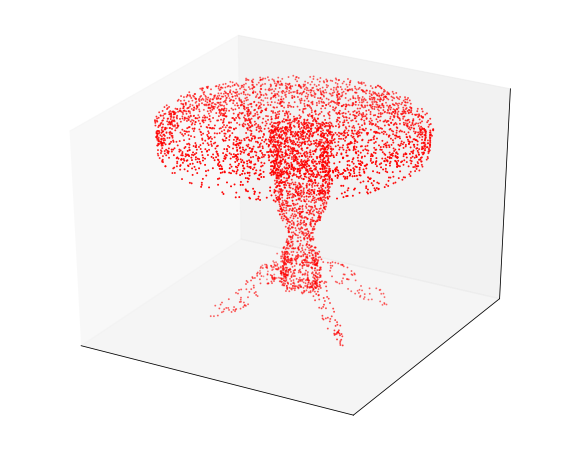

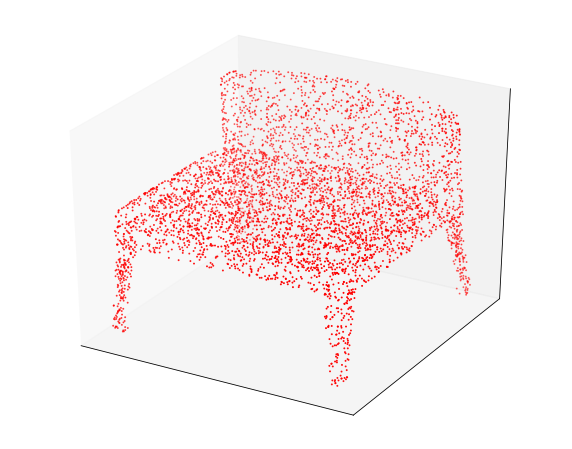

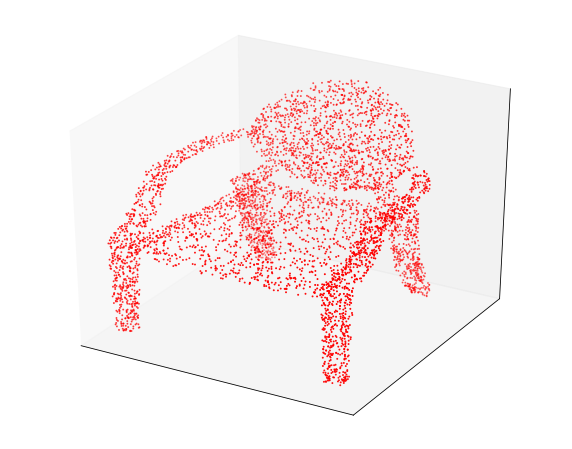

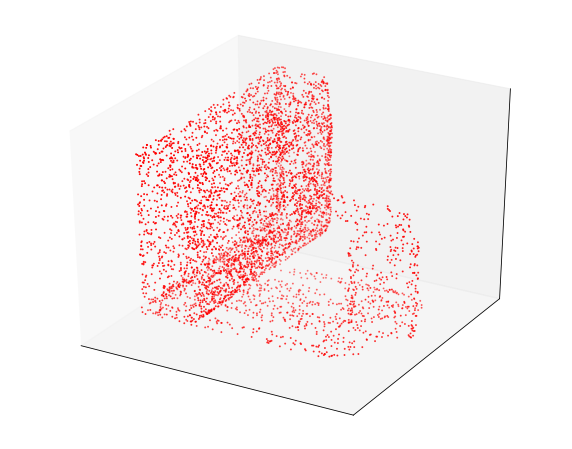

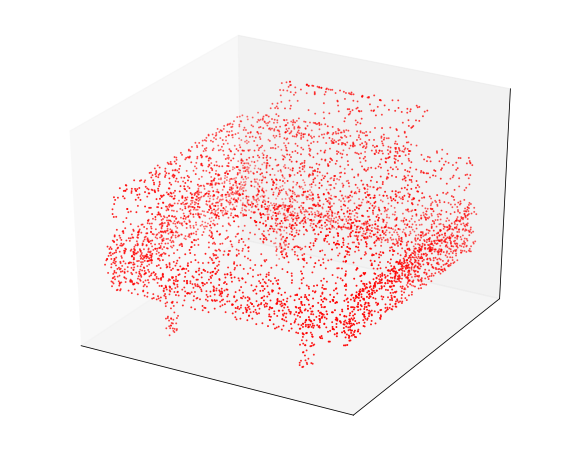

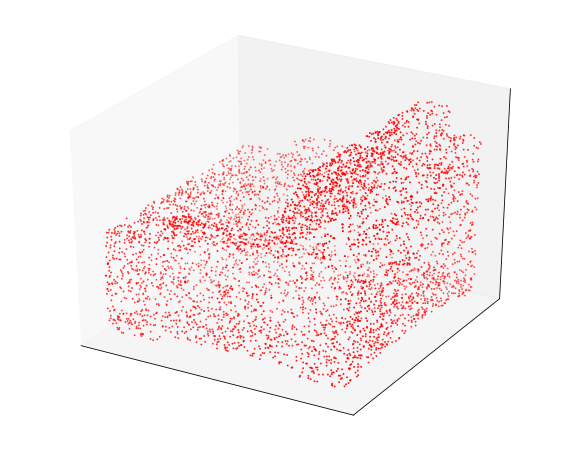

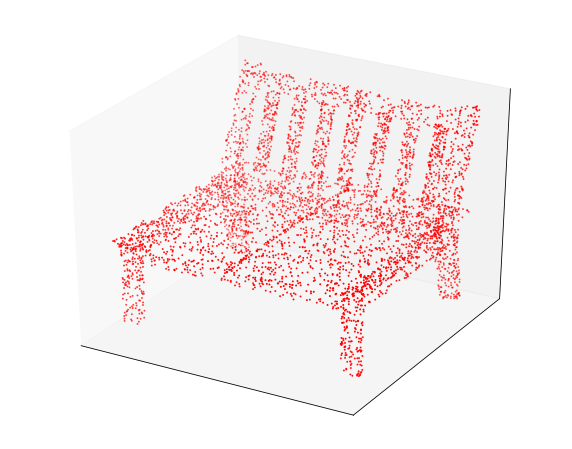

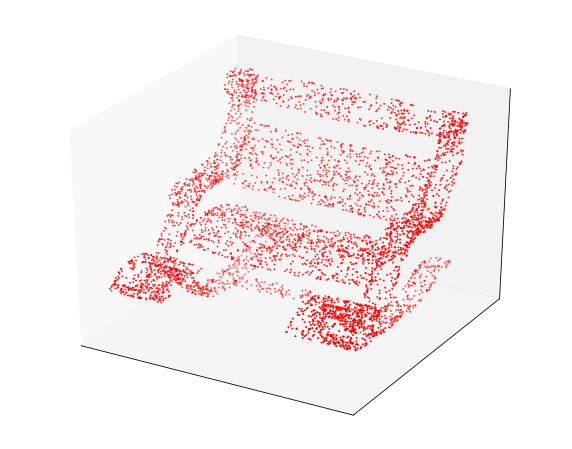

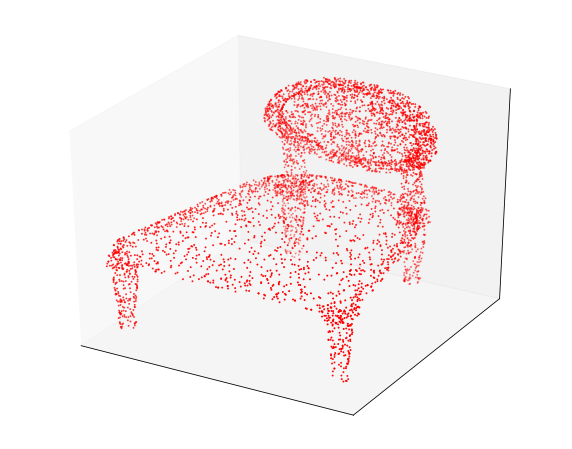

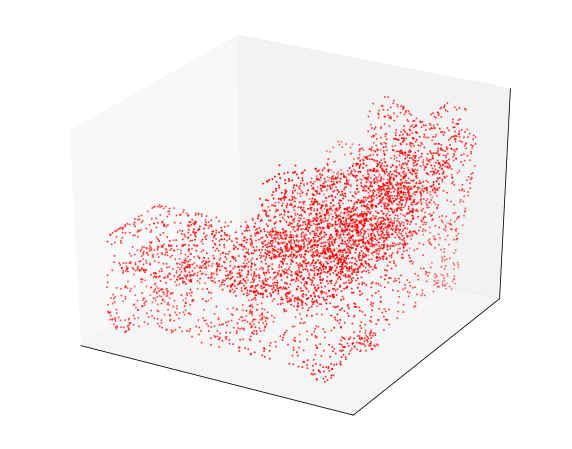

In [14]:
for i in range(10):
    visualize_npy(X_train[i], save_img_fpath='./img/modelnet10_'+ str(i) +'.png')

In [15]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
train_ds = PointDriftDS(X_train, y_train)
test_ds = PointDriftDS(X_test, y_test)

# train autodecoder
mn_autodecoder = train_decoder(adnet_HP, DS, train_ds=train_ds,
                               test_ds=test_ds, save_wt_fname='mnet_decoder.pth')

# get the train encodings
train_encoding_ds = EncodingDS(PointDriftDS(
    X_train, y_train), mn_autodecoder)
train_result = train_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

# get the test encodings
test_encoding_ds = EncodingDS(PointDriftDS(
    X_test, y_test), mn_autodecoder)
test_result = test_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

Epoch: 0. batch_idx: 100
Loss:  6752185.71969284 5815007.490593872
0 20039.639 tensor(7.1674, device='cuda:0', grad_fn=<NormBackward0>)
0 20098.572 tensor(7.2595, device='cuda:0', grad_fn=<NormBackward0>)
0 591267.25 tensor(7.2390, device='cuda:0', grad_fn=<NormBackward0>)
0 628942.94 tensor(7.2413, device='cuda:0', grad_fn=<NormBackward0>)
0 7252.4736 tensor(7.3386, device='cuda:0', grad_fn=<NormBackward0>)
0 195187.83 tensor(7.2932, device='cuda:0', grad_fn=<NormBackward0>)
0 235682.16 tensor(7.3234, device='cuda:0', grad_fn=<NormBackward0>)
0 27090.158 tensor(7.2493, device='cuda:0', grad_fn=<NormBackward0>)
0 12652.7 tensor(7.2263, device='cuda:0', grad_fn=<NormBackward0>)
0 970161.75 tensor(7.1766, device='cuda:0', grad_fn=<NormBackward0>)
0 1051.94 tensor(7.1971, device='cuda:0', grad_fn=<NormBackward0>)
0 672.38007 tensor(7.2433, device='cuda:0', grad_fn=<NormBackward0>)
0 1067.1549 tensor(7.2745, device='cuda:0', grad_fn=<NormBackward0>)
0 20846.201 tensor(7.1762, device='cuda:

0 3115.96 tensor(5.1167, device='cuda:0', grad_fn=<NormBackward0>)
0 209.44113 tensor(5.1823, device='cuda:0', grad_fn=<NormBackward0>)
0 2388.5466 tensor(5.1135, device='cuda:0', grad_fn=<NormBackward0>)
0 6521.688 tensor(5.0505, device='cuda:0', grad_fn=<NormBackward0>)
0 50081856.0 tensor(5.1419, device='cuda:0', grad_fn=<NormBackward0>)
0 787.9613 tensor(5.0970, device='cuda:0', grad_fn=<NormBackward0>)
0 2121.385 tensor(5.1348, device='cuda:0', grad_fn=<NormBackward0>)
0 1479.2146 tensor(5.1903, device='cuda:0', grad_fn=<NormBackward0>)
0 10051.558 tensor(5.1390, device='cuda:0', grad_fn=<NormBackward0>)
0 9065.826 tensor(5.1947, device='cuda:0', grad_fn=<NormBackward0>)
0 1058.3041 tensor(5.1260, device='cuda:0', grad_fn=<NormBackward0>)
0 325951.56 tensor(5.1653, device='cuda:0', grad_fn=<NormBackward0>)
0 331081.44 tensor(5.0634, device='cuda:0', grad_fn=<NormBackward0>)
0 16158.679 tensor(5.0817, device='cuda:0', grad_fn=<NormBackward0>)
0 12521.142 tensor(5.2166, device='cuda

0 7048.5923 tensor(5.0656, device='cuda:0', grad_fn=<NormBackward0>)
0 688.57007 tensor(5.0343, device='cuda:0', grad_fn=<NormBackward0>)
0 462.80106 tensor(5.0806, device='cuda:0', grad_fn=<NormBackward0>)
0 982.1292 tensor(5.1044, device='cuda:0', grad_fn=<NormBackward0>)
0 15541.357 tensor(5.0994, device='cuda:0', grad_fn=<NormBackward0>)
0 881.45154 tensor(5.0797, device='cuda:0', grad_fn=<NormBackward0>)
0 1543.2992 tensor(5.1207, device='cuda:0', grad_fn=<NormBackward0>)
0 1681.0492 tensor(5.1134, device='cuda:0', grad_fn=<NormBackward0>)
0 1221.5878 tensor(5.1030, device='cuda:0', grad_fn=<NormBackward0>)
0 19350.889 tensor(5.0138, device='cuda:0', grad_fn=<NormBackward0>)
0 354315.5 tensor(5.1572, device='cuda:0', grad_fn=<NormBackward0>)
0 10701.856 tensor(5.1283, device='cuda:0', grad_fn=<NormBackward0>)
0 630.21576 tensor(5.1415, device='cuda:0', grad_fn=<NormBackward0>)
0 11454.523 tensor(5.0480, device='cuda:0', grad_fn=<NormBackward0>)
0 10572.007 tensor(5.1696, device='c

0 38302.332 tensor(5.1951, device='cuda:0', grad_fn=<NormBackward0>)
0 37601.418 tensor(5.0993, device='cuda:0', grad_fn=<NormBackward0>)
0 509.86856 tensor(5.1174, device='cuda:0', grad_fn=<NormBackward0>)
0 108156.39 tensor(5.0829, device='cuda:0', grad_fn=<NormBackward0>)
0 912.0443 tensor(5.1264, device='cuda:0', grad_fn=<NormBackward0>)
0 602762.94 tensor(5.1093, device='cuda:0', grad_fn=<NormBackward0>)
0 256618.47 tensor(5.0814, device='cuda:0', grad_fn=<NormBackward0>)
0 1838.02 tensor(5.1103, device='cuda:0', grad_fn=<NormBackward0>)
0 552.7644 tensor(5.0234, device='cuda:0', grad_fn=<NormBackward0>)
0 249.37743 tensor(5.1457, device='cuda:0', grad_fn=<NormBackward0>)
0 372.35977 tensor(5.1220, device='cuda:0', grad_fn=<NormBackward0>)
0 363602.84 tensor(5.0888, device='cuda:0', grad_fn=<NormBackward0>)
0 7635.428 tensor(5.1719, device='cuda:0', grad_fn=<NormBackward0>)
0 1229.4293 tensor(5.2056, device='cuda:0', grad_fn=<NormBackward0>)
0 177.04071 tensor(5.1061, device='cuda

0 259404.56 tensor(3.6562, device='cuda:0', grad_fn=<NormBackward0>)
Encodings trained
0 1271.5074 tensor(5.1119, device='cuda:0', grad_fn=<NormBackward0>)
0 2456.4468 tensor(5.1659, device='cuda:0', grad_fn=<NormBackward0>)
0 476807.06 tensor(5.1423, device='cuda:0', grad_fn=<NormBackward0>)
0 2345.6902 tensor(5.1813, device='cuda:0', grad_fn=<NormBackward0>)
0 1619031.8 tensor(5.1033, device='cuda:0', grad_fn=<NormBackward0>)
0 188607.58 tensor(5.1698, device='cuda:0', grad_fn=<NormBackward0>)
0 2835.4229 tensor(5.1130, device='cuda:0', grad_fn=<NormBackward0>)
0 474602.62 tensor(5.1918, device='cuda:0', grad_fn=<NormBackward0>)
0 2893.503 tensor(5.1243, device='cuda:0', grad_fn=<NormBackward0>)
0 5048.612 tensor(5.2157, device='cuda:0', grad_fn=<NormBackward0>)
0 1507.5796 tensor(5.1043, device='cuda:0', grad_fn=<NormBackward0>)
0 4349.5894 tensor(5.2201, device='cuda:0', grad_fn=<NormBackward0>)
0 474613.1 tensor(5.1338, device='cuda:0', grad_fn=<NormBackward0>)
0 17718.732 tensor(

In [20]:
# train the compnet
HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)
mn_compnet = train_compnet(HP, DS,
                           train_ds=train_encoding_ds, test_ds=test_encoding_ds,
                           save_wt_fname='mnet_compnet.pth',)

Epoch: 0. batch_idx: 100
Loss:  0.6149911051988601 0.7460800391435624
Epoch: 0. batch_idx: 200
Loss:  0.6299314761161804 0.6936945408582688
------------------ Evaluation Report ------------------
Total Accuracy: 0.6052631578947368
After 25 batches and 399 test points

Metrics for the same class:
Avg loss: 0.5342920589447021
Precision: 0.5734265734265734
Recall: 0.8220551378446115
F1 Score: 0.6755921730175078

Metrics for the diff class:
Avg loss: 0.7931798696517944
Precision: 0.6858407079646017
Recall: 0.38847117794486213
F1 Score: 0.49600000000000005
Eval:  (13.357301473617554, 19.82949674129486, 328.0, 155.0, 71.0, 244.0, 25, 399)
Epoch: 1. batch_idx: 100
Loss:  0.6382080662250519 0.6716834247112274
Epoch: 1. batch_idx: 200
Loss:  0.6337606886029243 0.6510091039538384
Epoch: 2. batch_idx: 100
Loss:  0.6194563519954681 0.6517109248042107
Epoch: 2. batch_idx: 200
Loss:  0.6440279445052147 0.6423663350939751
Epoch: 3. batch_idx: 100
Loss:  0.6296136441826821 0.6320118486881257
Epoch: 3.

## Single CompNet result on ModelNet10 Data

In [21]:
# evaluate compnet
eval_compnet(mn_compnet, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.6328320802005013
After 25 batches and 399 test points

Metrics for the same class:
Avg loss: 0.6721541428565979
Precision: 0.6142241379310345
Recall: 0.7142857142857143
F1 Score: 0.6604866743916571

Metrics for the diff class:
Avg loss: 0.6475768661499024
Precision: 0.6586826347305389
Recall: 0.5513784461152882
F1 Score: 0.6002728512960437


(16.803853571414948, 16.18942165374756, 285.0, 220.0, 114.0, 179.0, 25, 399)

### Train Ensemble CompNet1 on ModelNet10 Data

In [22]:
ensemble_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)

# Train with the ensemble net
ensemble1 = train_compnet(ensemble_HP, DS,
                           train_ds=train_encoding_ds,
                           test_ds=test_encoding_ds,
                           save_wt_fname='mnet_ensemble1.pth',
                           compnet=EnsembleCompNet())

Epoch: 0. batch_idx: 100
Loss:  0.8254288733005524 0.5902452933788299
Epoch: 0. batch_idx: 200
Loss:  0.7108312165737152 0.673785789012909
------------------ Evaluation Report ------------------
Total Accuracy: 0.5676691729323309
After 25 batches and 399 test points

Metrics for the same class:
Avg loss: 0.6577293205261231
Precision: 0.5454545454545454
Recall: 0.8120300751879699
F1 Score: 0.6525679758308157

Metrics for the diff class:
Avg loss: 0.7270295357704163
Precision: 0.6323529411764706
Recall: 0.3233082706766917
F1 Score: 0.42786069651741293
Eval:  (16.443233013153076, 18.175738394260406, 324.0, 129.0, 75.0, 270.0, 25, 399)
Epoch: 1. batch_idx: 100
Loss:  0.652720433473587 0.7364459753036499
Epoch: 1. batch_idx: 200
Loss:  0.623364406824112 0.7428136426210403
Epoch: 2. batch_idx: 100
Loss:  0.6077224254608155 0.7507408505678177
Epoch: 2. batch_idx: 200
Loss:  0.5829259717464447 0.7430643290281296
Epoch: 3. batch_idx: 100
Loss:  0.5798627632856369 0.7355458235740662
Epoch: 3. ba

### Evaluate Ensemble CompNet1 on ModelNet10 Data

In [23]:
eval_compnet(ensemble1, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.7468671679197995
After 25 batches and 399 test points

Metrics for the same class:
Avg loss: 0.5142248192429543
Precision: 0.742014742014742
Recall: 0.7568922305764411
F1 Score: 0.7493796526054591

Metrics for the diff class:
Avg loss: 0.5207182443141938
Precision: 0.7519181585677749
Recall: 0.7368421052631579
F1 Score: 0.7443037974683544


(12.855620481073856, 13.017956107854843, 302.0, 294.0, 97.0, 105.0, 25, 399)